# Bike Safety Final Models

## Introduction

The goal of this project is to create a Predictive Model that is able to predict how severe a bike accident was:

For this, we have two target columns we plan to use in different ways:
- BikeInjury, which classifies how severe the injury of a biker was: from No Injury to Killed.
- AmbulanceR, which tells us whether an ambulance was called or not to the scene.

In the following sections, we'll tackle different ways of using these columns as our target column.

In this section, we'll set up the code required for all approaches.

In [50]:
# Visualization and data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing and metrics libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, learning_curve

# Machine learning models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Read out our database of bike accidents
BikeCrashData = pd.read_csv('../data/NCDOT_BikePedCrash.csv')

# Keeping only the relevant columns
BikeCrashData = BikeCrashData[['AmbulanceR',
        'BikeAgeGrp','BikeDir', 'BikeInjury', 'BikePos','BikeRace', 'BikeSex', 
        'CrashDay', 'CrashHour', 'CrashMonth',
        'NumLanes','RdConditio', 'RdConfig','RdFeature', 'RdSurface', 'RuralUrban', 'SpeedLimit', 'Weather', 'Workzone']]


# Recombining speed limit into three categories
# 1. Low (0-25 mph)
# 2. Medium (26-45 mph)
# 3. High (46+ mph)
def speed_limit(x):
    if x in ['5 - 15 MPH', '20 - 25  MPH', 'Unknown']:
        return 0
    
    elif x in ['30 - 35  MPH', '40 - 45  MPH']:
        return 1
    
    else:
        return 2
    
BikeCrashData['SpeedLimit']=BikeCrashData['SpeedLimit'].apply(speed_limit)

# Combine months into seasons
def month_season(x):
    if x in ['December','January', 'February']:
        return 0
    
    elif x in ['March','April', 'May']:
        return 1
    
    elif x in ['June','July', 'August']:
        return 2
    
    else:
        return 3

BikeCrashData['CrashMonth']=BikeCrashData['CrashMonth'].apply(month_season)

# Combine hours into day parts
def day_part(hour):
    if hour < 6:
        return 0
    
    elif hour < 12:
        return 1
    
    elif hour < 18:
        return 2
    
    else:
        return 3
    
BikeCrashData['CrashHour']=BikeCrashData['CrashHour'].apply(day_part)

# Combinging age groups in three categories
def age_group(x):
    if x in ['0-5', '6-10', '11-15', '16-19']:
        return 0
    
    elif x in ['20-24', '25-29', '30-39' ]:
        return 1
    
    else:
        return 2

BikeCrashData['BikeAgeGrp']=BikeCrashData['BikeAgeGrp'].apply(age_group)

# Adding a binary column for the two main targets
BikeCrashData['AmbulanceR']=BikeCrashData['AmbulanceR'].apply(lambda x: 1 if x == 'No' else 0) ##### NOTE THE CHANGE in notation here

# Dropping unknown injuries
BikeCrashData.drop(BikeCrashData[BikeCrashData['BikeInjury'] == 'Unknown Injury'].index, inplace=True)

# Recombining injuries into two main classes (Light '1' and Severe '0')
BikeCrashData['BikeInjury']=BikeCrashData['BikeInjury'].replace({'B: Suspected Minor Injury':0,'C: Possible Injury':0, 'O: No Injury':0,'K: Killed':1,'A: Suspected Serious Injury':1 })
# Again, NOTE keeping the minority class as 1 and the majority class as 0. This is important for the model to work properly.

# For other features, we just use get dummies to convert them into binary features
BikeCrashData = pd.get_dummies(BikeCrashData, columns=['BikeDir','CrashDay', 'BikePos','BikeRace', 'BikeSex','NumLanes','RdConditio', 'RdConfig','RdFeature', 'RdSurface', 'RuralUrban', 'Weather', 'Workzone'])*1

C:\Users\xgr6vm\AppData\Local\Temp\ipykernel_26060\2197383662.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  BikeCrashData['BikeInjury']=BikeCrashData['BikeInjury'].replace({'B: Suspected Minor Injury':0,'C: Possible Injury':0, 'O: No Injury':0,'K: Killed':1,'A: Suspected Serious Injury':1 })


In [20]:
def model_metrics(model, X_train, y_train, n_splits):
    """
    model_metrics function is used to evaluate the model performance using k-fold cross-validation.
    It calculates various metrics such as accuracy, precision, recall, f1-score, and roc_auc_score and returns the mean of these metrics.
    The function also visualizes the confusion matrix for each fold.

    :param model: the machine learning model to be evaluated
    :param X_train: the training data features
    :param y_train: the training data target variable
    :param n_splits: the number of splits for k-fold cross-validation
    :return: returns a dictionary containing the mean of the evaluation metrics
    """ 

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    kfold = StratifiedKFold(n_splits,
              shuffle = True,
              random_state = 582)
    
    fig, axis = plt.subplots(1, n_splits, figsize=(20, 5))
    
    for index, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        # training sets
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
        # holdout sets
        X_ho = X_train.iloc[test_index]
        y_ho = y_train.iloc[test_index]

        # train and evaluate model
        model.fit(X_tt, y_tt)
        pred = model.predict(X_ho)

        # collect the evaluation metric of each fold
        accuracy_scores.append(accuracy_score(y_ho, pred))
        precision_scores.append(precision_score(y_ho, pred))
        recall_scores.append(recall_score(y_ho, pred))
        f1_scores.append(f1_score(y_ho, pred))
        roc_auc_scores.append(roc_auc_score(y_ho, pred))
        ConfusionMatrixDisplay.from_predictions(y_ho, pred, ax=axis[index])
        axis[index].set_title("Split " + str(index+1))

    plt.show()
    return {'accuracy' : np.mean(accuracy_scores),
            'precision' : np.mean(precision_scores),
            'recall' : np.mean(recall_scores),
            'f1-score' : np.mean(f1_scores),
            'roc_auc_score'  : np.mean(roc_auc_scores)}

In [23]:
# Extending the LogisticRegression class to include a threshold parameter
class LogisticRegressionThreshold(LogisticRegression):
    def __init__(self, threshold=0.5, penalty='l2', dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None):
        super().__init__(penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio)
        self.threshold = threshold

    def predict(self, X):
        y_prob = self.predict_proba(X)
        return (y_prob[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return super().predict_proba(X)

In [ ]:
# Some starting models to try out
models = {'logistic_regression_unweighted': LogisticRegression(penalty=None, max_iter=1000),
          'logistic_regression_weighted' : LogisticRegression(penalty=None, max_iter=1000, class_weight='balanced'),
          'random_forest_weighted' : RandomForestClassifier(n_estimators=500, max_depth=6, class_weight='balanced')}

## Target: Ambulance Response

### Cross Validation

We'll first test our models using the AmbulanceR column as our target.

Notice in the code below, we don't touch the Bike_test.

We only do the cross-validation on the training data set.

#### Set-up

In [55]:
# Splitting the data into training and test sets, stratifying on Ambulance Response
Bike_train, Bike_test = train_test_split(BikeCrashData.copy(),
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=614,
                                        stratify=BikeCrashData['AmbulanceR'])

features = Bike_train.drop(columns=['AmbulanceR','BikeInjury']).columns
X_train = Bike_train[features]
y_train = Bike_train['AmbulanceR']

In [56]:
# Create a list of class weights to test out in different models
class_weights_ambulance_r = list(range(40, 91))
class_weights_ambulance_r = [{0: weight, 1: 100 - weight} for weight in class_weights_ambulance_r]

In [57]:
# Using GridSearchCV to find the best hyperparameters for the Logistic Regression model
# The threshold is tested from 0.3 to 0.5 in increments of 0.01, and the class weights are above
grid_cv = GridSearchCV(LogisticRegressionThreshold(), 
                          param_grid = {'threshold': [threshold / 100 for threshold in list(range(30, 50))], 
                                        'max_iter': [1000],
                                        'class_weight': class_weights_ambulance_r}, 
                          scoring = 'f1', 
                          cv = 5)

grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models['logistic_regression_grid_cv'] = grid_cv.best_estimator_

c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\l

In [ ]:
# Print out models
models

{'logistic_regression_unweighted': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression_weighted': LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None),
 'random_forest_weighted': RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=500),
 'logistic_regression_grid_cv': LogisticRegressionThreshold(class_weight={0: 40, 1: 60}, max_iter=1000,
                             threshold=0.3)}

#### Results

MODEL: logistic_regression_unweighted
CONFUSION MATRICES:


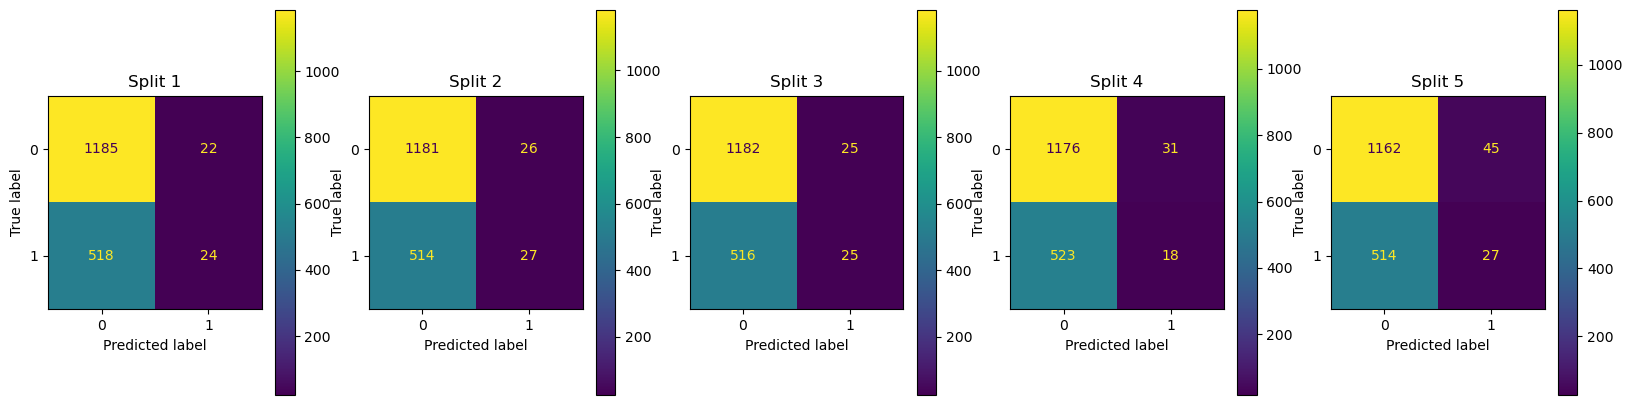

AVERAGE METRICS:
accuracy : 0.6872206805327136
precision : 0.4547040062948888
recall : 0.04471560796938838
f1-score : 0.08125048319718467
roc_auc_score : 0.5100131478123661
-----------------------------------


MODEL: logistic_regression_weighted
CONFUSION MATRICES:


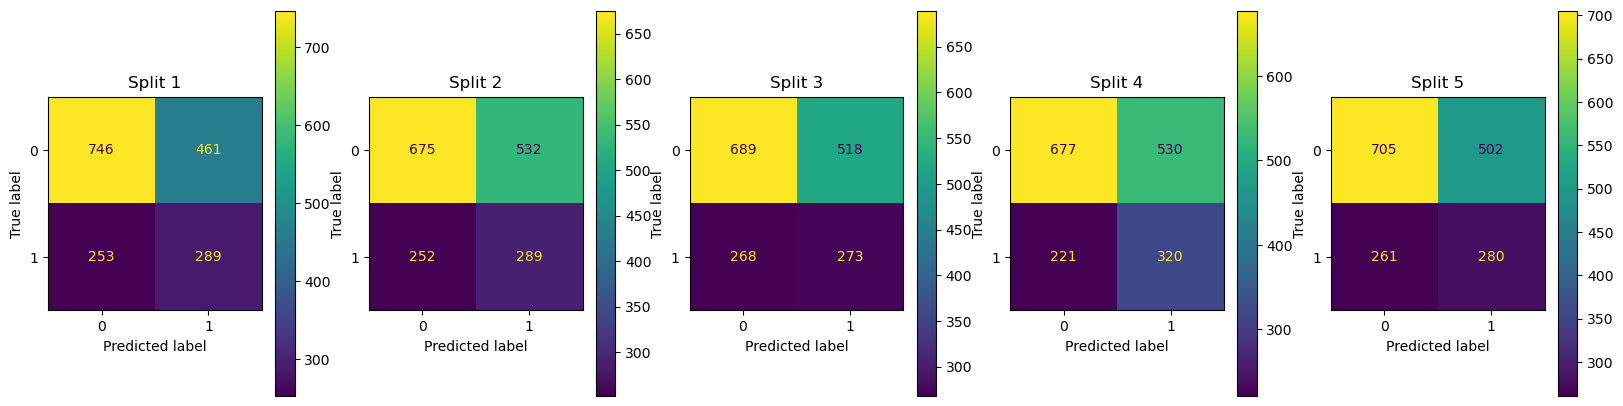

AVERAGE METRICS:
accuracy : 0.5654929328691256
precision : 0.3634005350260973
recall : 0.5362169277885015
f1-score : 0.4330070638054976
roc_auc_score : 0.5574208085504231
-----------------------------------


MODEL: random_forest_weighted
CONFUSION MATRICES:


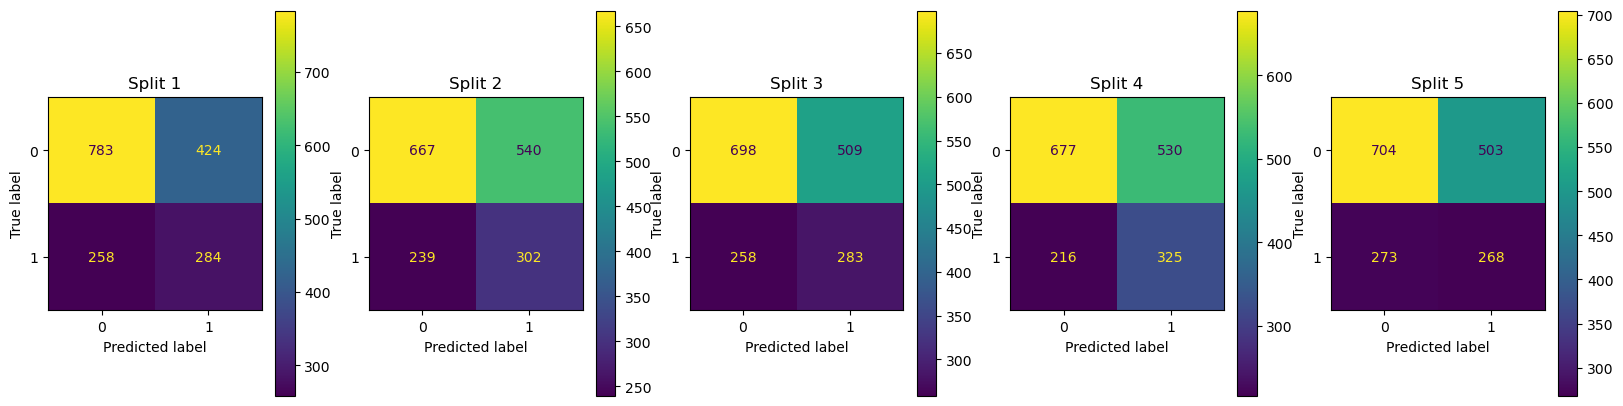

AVERAGE METRICS:
accuracy : 0.5709828303325992
precision : 0.36896809748526904
recall : 0.5402868816118845
f1-score : 0.4379781050675172
roc_auc_score : 0.5625212369948404
-----------------------------------


MODEL: logistic_regression_grid_cv
CONFUSION MATRICES:


c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\l

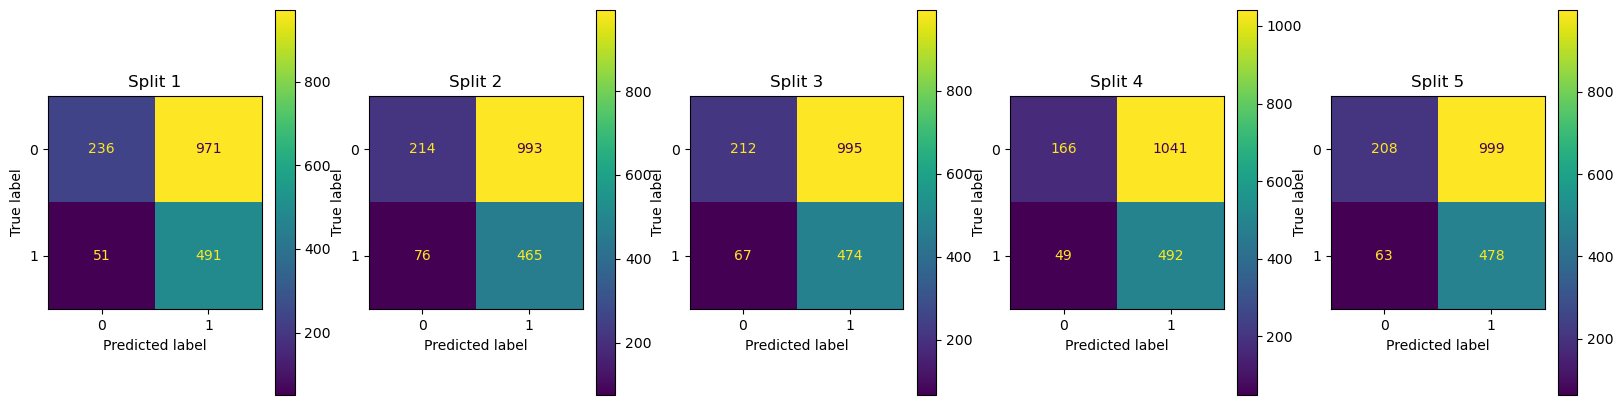

AVERAGE METRICS:
accuracy : 0.3930874523918865
precision : 0.32440162973553066
recall : 0.8869109411981366
f1-score : 0.4750152511980475
roc_auc_score : 0.5292881135153898
-----------------------------------




In [58]:
for (key, model) in models.items():
    print('MODEL:', key)
    print('CONFUSION MATRICES:')
    metrics = model_metrics(model, X_train, y_train, 5)
    print('AVERAGE METRICS:')
    for (metric, value) in metrics.items():
        print(metric, ':', value)
    print('-----------------------------------')
    print('\n')

#### Check Overfitting

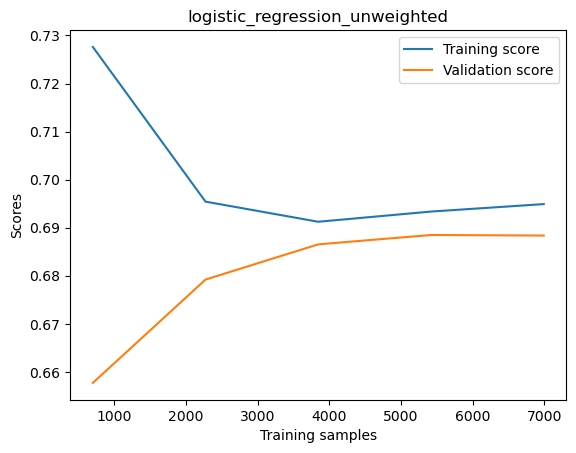

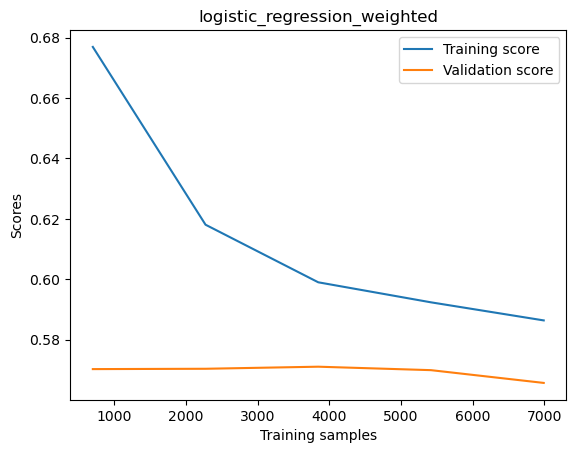

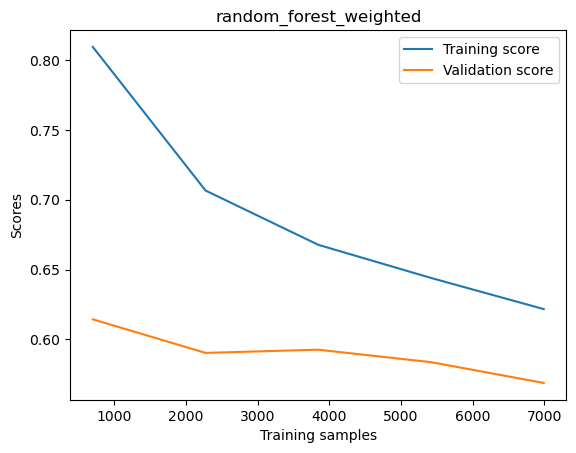

c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\l

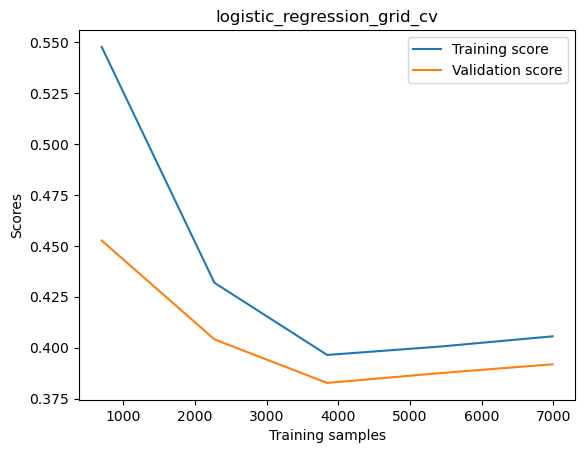

In [60]:
for (key, model) in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

### Final Evaluation

MODEL: logistic_regression_unweighted
CONFUSION MATRIX:


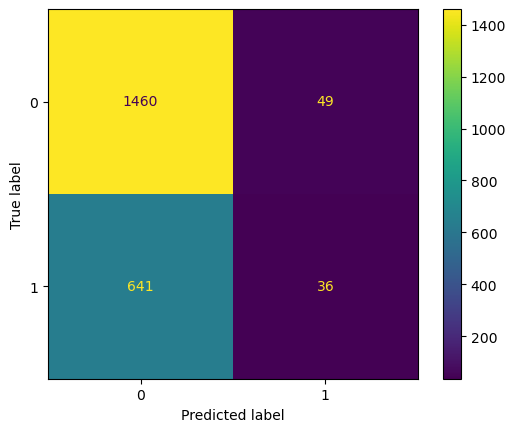

METRICS:
accuracy : 0.6843549862763038
precision : 0.4235294117647059
recall : 0.053175775480059084
f1-score : 0.09448818897637795
roc_auc_score : 0.5103519699136545
-----------------------------------


MODEL: logistic_regression_weighted
CONFUSION MATRIX:


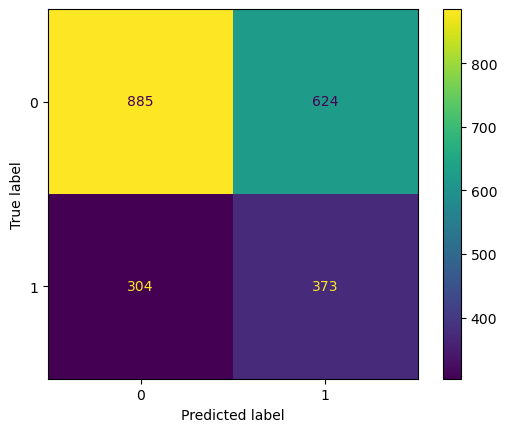

METRICS:
accuracy : 0.57548032936871
precision : 0.3741223671013039
recall : 0.55096011816839
f1-score : 0.44563918757467147
roc_auc_score : 0.5687206157442348
-----------------------------------


MODEL: random_forest_weighted
CONFUSION MATRIX:


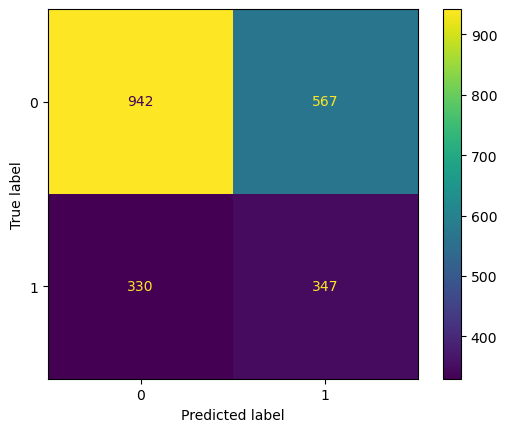

METRICS:
accuracy : 0.5896614821591949
precision : 0.3796498905908096
recall : 0.5125553914327917
f1-score : 0.43620364550597107
roc_auc_score : 0.5684049322969128
-----------------------------------


MODEL: logistic_regression_grid_cv
CONFUSION MATRIX:


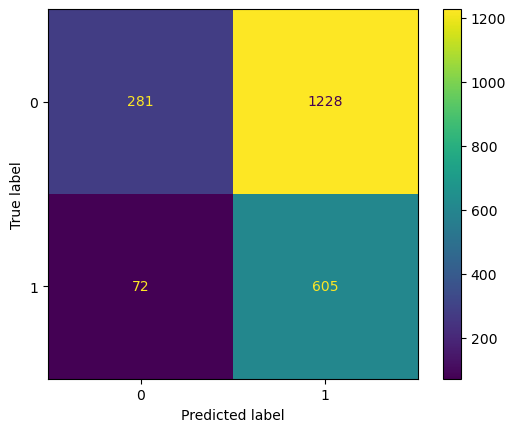

METRICS:
accuracy : 0.40530649588289114
precision : 0.33006001091107473
recall : 0.8936484490398818
f1-score : 0.4820717131474104
roc_auc_score : 0.5399322430752755
-----------------------------------




In [59]:
X_test = Bike_test[features]
y_test = Bike_test['AmbulanceR']

for (key, model) in models.items():
    # evaluate model
    y_pred = model.predict(X_test)

    print('MODEL:', key)
    print('CONFUSION MATRIX:')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('METRICS:')
    print('accuracy', ':', (accuracy_score(y_test, y_pred)))
    print('precision', ':', (precision_score(y_test, y_pred)))
    print('recall', ':', (recall_score(y_test, y_pred)))
    print('f1-score', ':', (f1_score(y_test, y_pred)))
    print('roc_auc_score', ':', (roc_auc_score(y_test, y_pred)))
    print('-----------------------------------')
    print('\n')

## Target: Bike Injury (Binary)

### Cross Validation

We'll first test our models using the BikeInjury column as our target. This has the following values:
- 'O: No Injury'
- 'C: Possible Injury'
- 'B: Suspected Minor Injury'
- 'A: Suspected Serious Injury'
- 'K: Killed':

To avoid complicating the model, we'll first test it by converting it into a binary column:
- 'A: Suspected Serious Injury' and 'K: Killed' is classified as 1, i.e. Severy Injury.
- Otherwise, it is classified as 0, i.e. Not Severy Injury.

Notice in the code below, we don't touch the Bike_test.

We only do the cross-validation on the training data set.

#### Set-up

In [33]:
# Splitting the data into training and test sets, stratifying on Ambulance Response
Bike_train, Bike_test = train_test_split(BikeCrashData.copy(),
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=614,
                                        stratify=BikeCrashData['BikeInjury'])

features = Bike_train.drop(columns=['AmbulanceR','BikeInjury']).columns
X_train = Bike_train[features]
y_train = Bike_train['BikeInjury']

In [ ]:
# Create a list of class weights to test out in different models
class_weights_bike_injury = list(range(40, 91))
class_weights_bike_injury = [{0: weight, 1: 100 - weight} for weight in class_weights_bike_injury]

In [ ]:
# Using GridSearchCV to find the best hyperparameters for the Logistic Regression model
# The threshold is tested from 0.3 to 0.5 in increments of 0.01, and the class weights are above
grid_cv = GridSearchCV(LogisticRegressionThreshold(), 
                          param_grid = {'threshold': [threshold / 100 for threshold in list(range(5, 25))], 
                                        'max_iter': [1000],
                                        'class_weight': class_weights_bike_injury}, 
                          scoring = 'f1', 
                          cv = 5)

grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models['logistic_regression_grid_cv'] = grid_cv.best_estimator_

c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\l

In [ ]:
# Print out models
models

{'logistic_regression_unweighted': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression_weighted': LogisticRegression(class_weight='balanced', max_iter=1000, penalty=None),
 'random_forest_weighted': RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=500),
 'logistic_regression_grid_cv': LogisticRegressionThreshold(class_weight={0: 56, 1: 44}, max_iter=1000,
                             threshold=0.11)}

#### Results

MODEL: logistic_regression_unweighted
CONFUSION MATRICES:


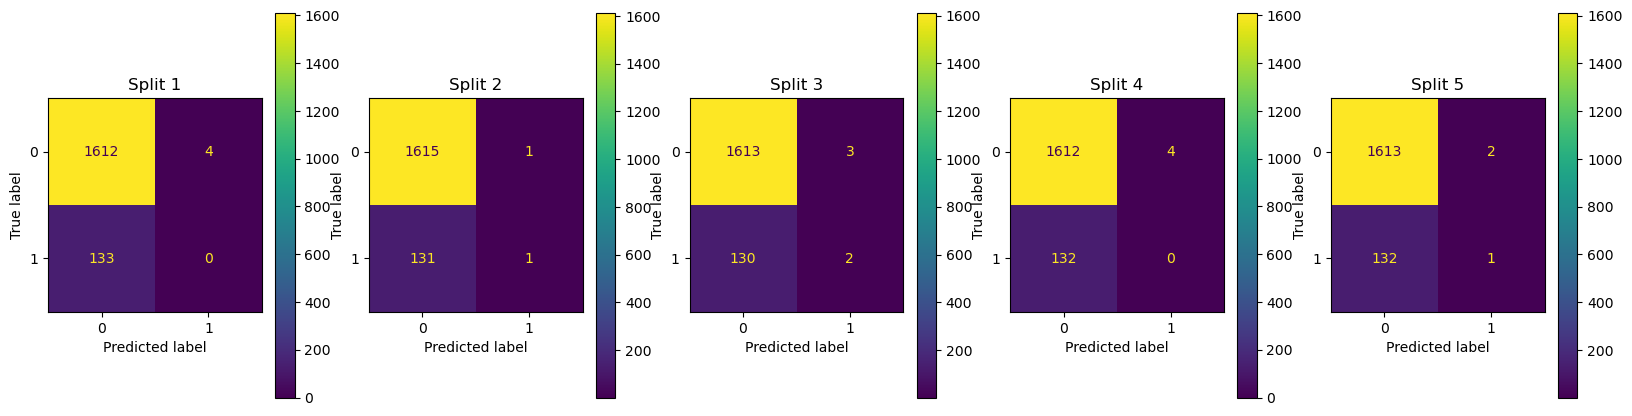

AVERAGE METRICS:
accuracy : 0.9231210904433131
precision : 0.24666666666666667
recall : 0.006049213943950786
f1-score : 0.011765667155848068
roc_auc_score : 0.5021581937052618
-----------------------------------


MODEL: logistic_regression_weighted
CONFUSION MATRICES:


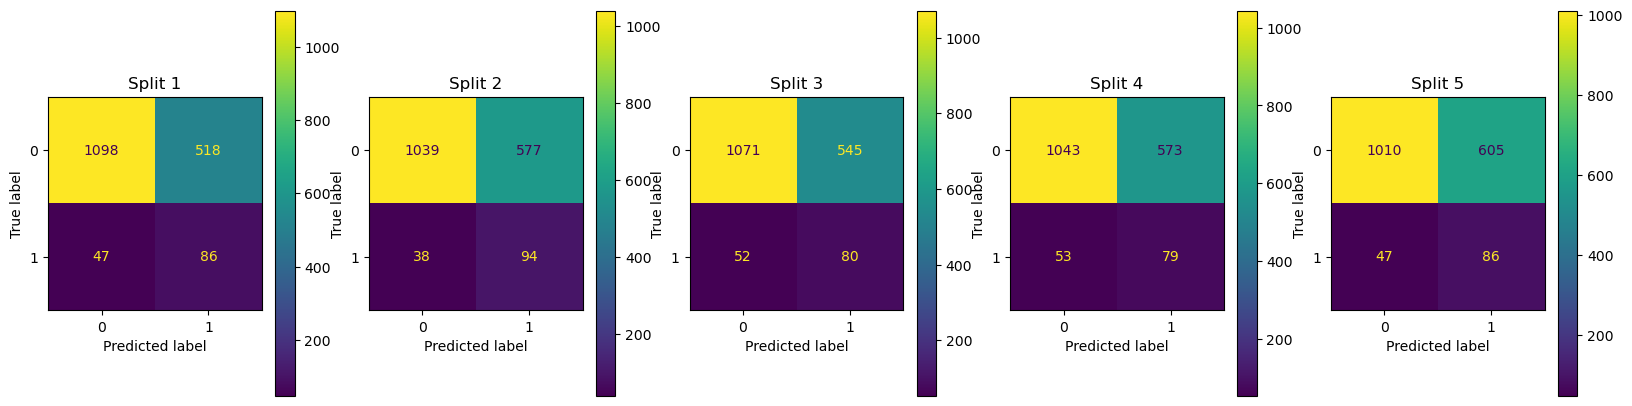

AVERAGE METRICS:
accuracy : 0.6504946272011598
precision : 0.1312192954317804
recall : 0.6419799498746868
f1-score : 0.21782594289649224
roc_auc_score : 0.6465856053208151
-----------------------------------


MODEL: random_forest_weighted
CONFUSION MATRICES:


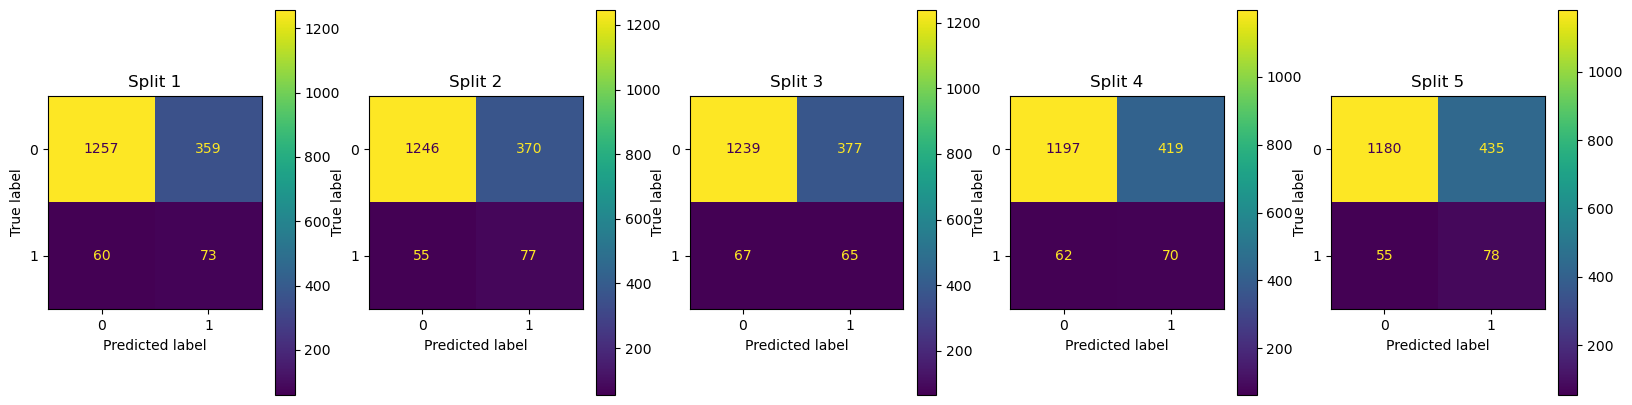

AVERAGE METRICS:
accuracy : 0.7415605910144143
precision : 0.1566991761440361
recall : 0.5482797903850535
f1-score : 0.24355852770257166
roc_auc_score : 0.6528360987912147
-----------------------------------


MODEL: logistic_regression_grid_cv
CONFUSION MATRICES:


c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\l

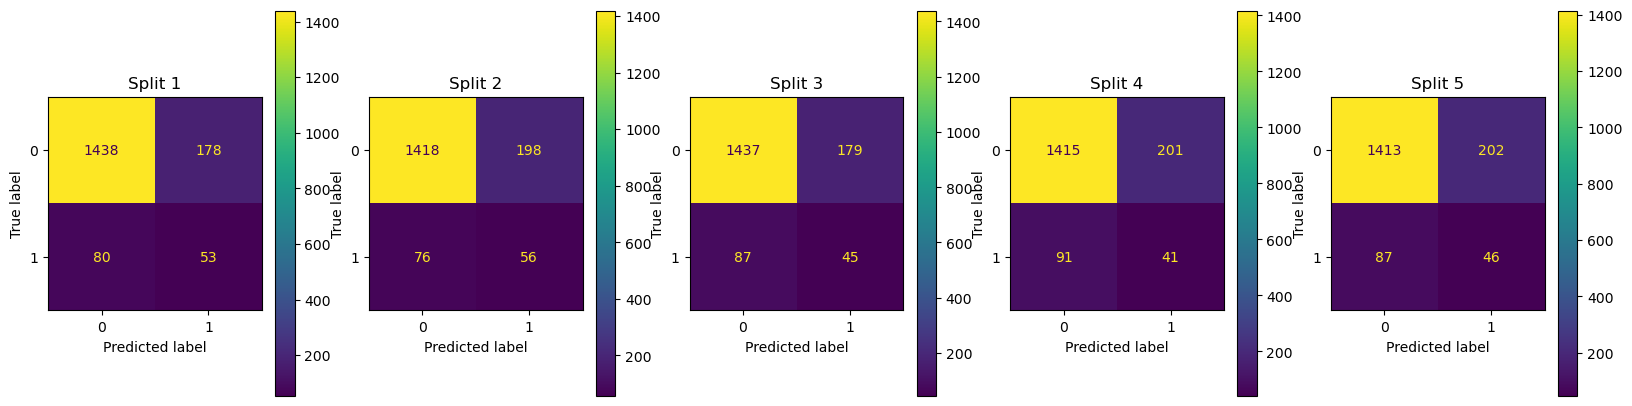

AVERAGE METRICS:
accuracy : 0.8422365575359831
precision : 0.20114157721920325
recall : 0.3640236956026429
f1-score : 0.2589788747117411
roc_auc_score : 0.6227219296454191
-----------------------------------




In [47]:
for (key, model) in models.items():
    print('MODEL:', key)
    print('CONFUSION MATRICES:')
    metrics = model_metrics(model, X_train, y_train, 5)
    print('AVERAGE METRICS:')
    for (metric, value) in metrics.items():
        print(metric, ':', value)
    print('-----------------------------------')
    print('\n')

#### Check Overfitting

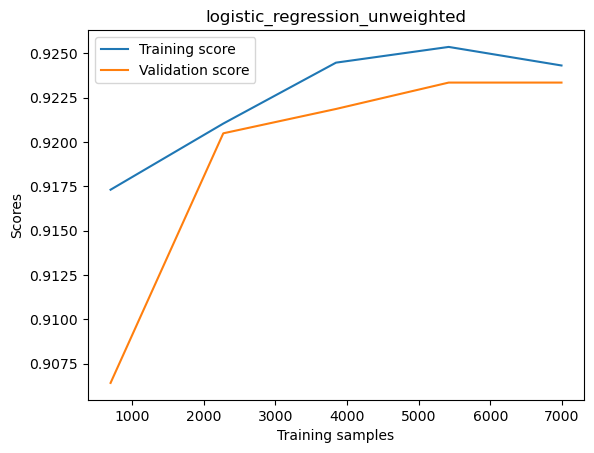

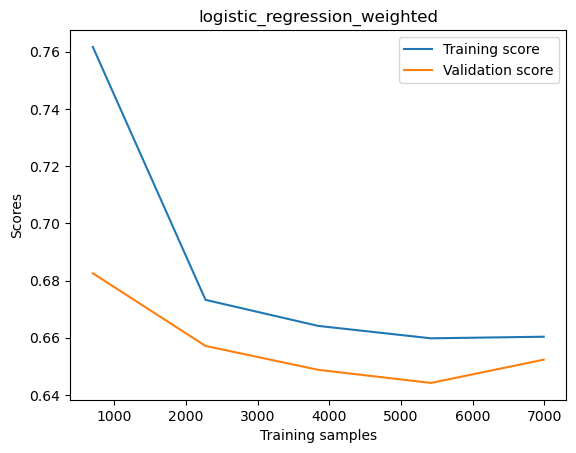

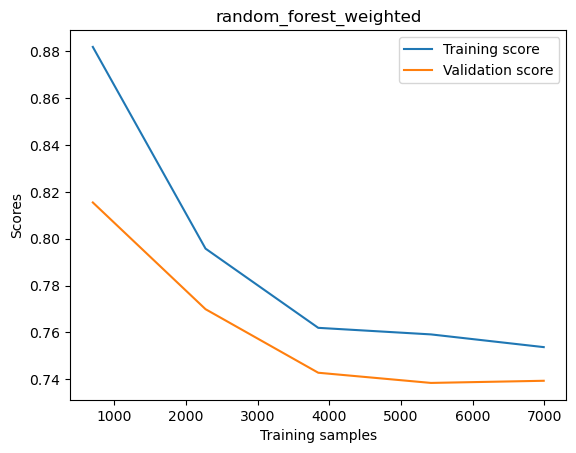

c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\xgr6vm\.conda\envs\erdos_spring_2025\Lib\site-packages\sklearn\l

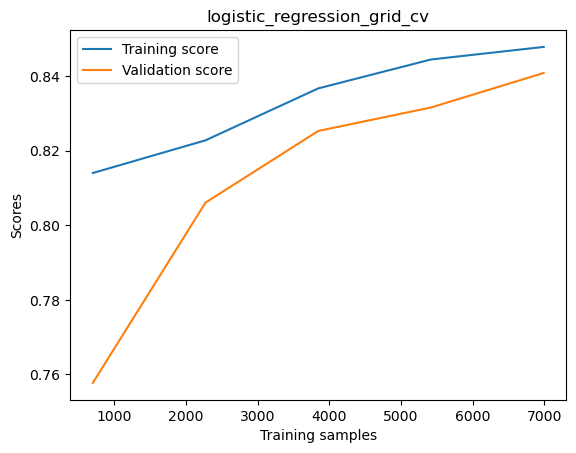

In [53]:
for (key, model) in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

### Final Evaluation

MODEL: logistic_regression_unweighted
CONFUSION MATRIX:


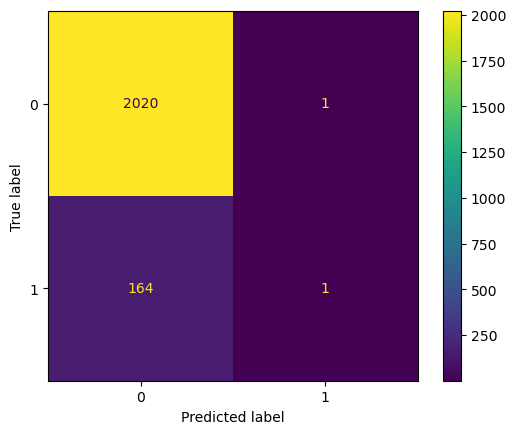

METRICS:
accuracy : 0.92451967063129
precision : 0.5
recall : 0.006060606060606061
f1-score : 0.011976047904191617
roc_auc_score : 0.5027829007542022
-----------------------------------


MODEL: logistic_regression_weighted
CONFUSION MATRIX:


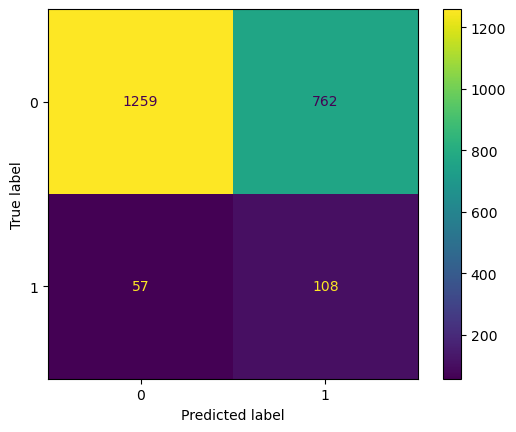

METRICS:
accuracy : 0.6253430924062214
precision : 0.12413793103448276
recall : 0.6545454545454545
f1-score : 0.20869565217391303
roc_auc_score : 0.6387521928838109
-----------------------------------


MODEL: random_forest_weighted
CONFUSION MATRIX:


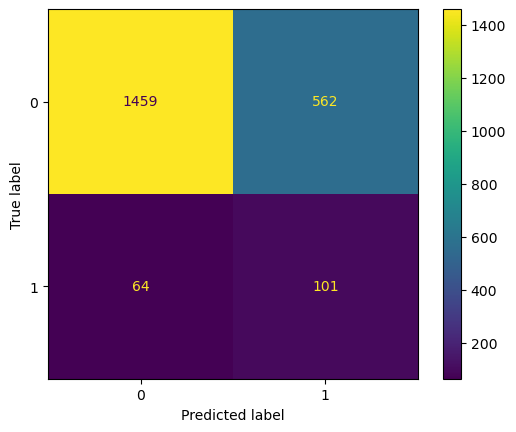

METRICS:
accuracy : 0.7136322049405307
precision : 0.15233785822021115
recall : 0.6121212121212121
f1-score : 0.24396135265700483
roc_auc_score : 0.6670205268918776
-----------------------------------


MODEL: logistic_regression_grid_cv
CONFUSION MATRIX:


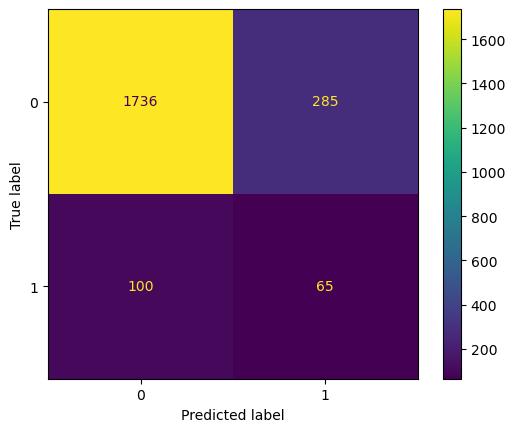

METRICS:
accuracy : 0.82387923147301
precision : 0.18571428571428572
recall : 0.3939393939393939
f1-score : 0.2524271844660194
roc_auc_score : 0.626460048280929
-----------------------------------




In [48]:
X_test = Bike_test[features]
y_test = Bike_test['BikeInjury']

for (key, model) in models.items():
    # evaluate model
    y_pred = model.predict(X_test)

    print('MODEL:', key)
    print('CONFUSION MATRIX:')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('METRICS:')
    print('accuracy', ':', (accuracy_score(y_test, y_pred)))
    print('precision', ':', (precision_score(y_test, y_pred)))
    print('recall', ':', (recall_score(y_test, y_pred)))
    print('f1-score', ':', (f1_score(y_test, y_pred)))
    print('roc_auc_score', ':', (roc_auc_score(y_test, y_pred)))
    print('-----------------------------------')
    print('\n')